In [52]:
#!/usr/bin/env python

# NMME_WTing.ipynb

In [1]:
'''
    File name: NMME_WTing.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.03.2021
    Date last modified: 04.03.2021

    ##############################################################
    Purpos:

    1) Read in NMME variables over season and period of interest

    2) Read in the ERA-Interim WTs for the region

    3) Preprocess the data for the WTing

    4) Assign WTs to each day of the forecast and save the results

'''

'\n    File name: NMME_WTing.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 04.03.2021\n    Date last modified: 04.03.2021\n\n    ##############################################################\n    Purpos:\n\n    1) Read in NMME variables over season and period of interest\n\n    2) Read in the ERA-Interim WTs for the region\n\n    3) Preprocess the data for the WTing\n\n    4) Assign WTs to each day of the forecast and save the results\n\n'

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import scipy.ndimage
import matplotlib.path as mplPath
from scipy.interpolate import interp1d
import time
from math import atan2, degrees, pi
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import csv
import pygrib
from scipy import interpolate
from scipy import signal
# from netcdftime import utime
from scipy.ndimage import gaussian_filter
import scipy.ndimage.filters as filters
from calendar import monthrange

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [3]:
########################################
#                            USER INPUT SECTION
NMME_YYYY=1990 #int(sys.argv[1])

mo = 4 #int(sys.argv[1]) # model implemented are [0,1,2,3]
iRegion = 0 # int(sys.argv[2])
WTsort = [[0,2,1],[1,2,0],[1,2,0],[0,1,2]]

REFC_FORC = 'FORECAST'  # can be 'REFORECAST' or 'FORECAST'
# mo = 3 # model implemented are [0,1,2]
# sRegion = '1501'  # selected regions are '1501', '1502', 'HUC6-00', 'HUC6-03'

DataDirERAI='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
SRegionsAll = ['1501', '1502', 'HUC6-00', 'HUC6-03']
SRegionNames = ['AZ West', 'AZ East', 'NM North', 'NM South']
REGIONS = ['AZ_West','AZ_East','NM_North','NM_South']
sRegion = SRegionsAll[iRegion]
iSelReg = SRegionNames[SRegionsAll.index(sRegion)]

NMME_dir = '/glade/collections/cdg/data/nmme/output1/'
IFS_dir = '/glade/campaign/mmm/c3we/ECMWF/'
# center/model name, ensemble members, file convention
NMME_models = [['NCAR/CESM1',10,'day_CESM1'], #['CCCMA','NASA-GMAO','NCAR/CESM1', 'NCEP','NOAA-GFDL','UM-RSMAS']
               ['NASA-GMAO/GEOS-5',10,'day_GEOS-5'], # maskes out below surface areas --> use 650 hPa level
               ['UM-RSMAS/CCSM4', 10, 'day_CCSM4'],
               ['CCCMA/CanCM4', 10, 'day_CanCM4'],  # only has 675 hPa data
               ['IFS', 25, 'day_CanCM4']] # only 7 month forecast but 25 members
ConstantFile = [NMME_dir+'NCAR/CESM1/19820101/day/atmos/hus/hus_day_CESM1_19820101_r4i1p1_19820100-19821231.nc4',
               NMME_dir+'NASA-GMAO/GEOS-5/19820101/day/atmos/hus/hus_day_GEOS-5_19820101_r1i1p1.nc',
               NMME_dir+'UM-RSMAS/CCSM4/20050801/day/atmos/hus/hus_day_CCSM4_20050801_r10i1p1_20050801-20060731.nc',
               NMME_dir+'CCCMA/CanCM4/19840101/day/atmos/v20181101/hus/hus_day_CanCM4_198401_r10i1p1_19840101-19841231.nc4',
               IFS_dir+'20050601/Q_GDS0_ISBL/Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc']
DataDir = [NMME_dir,
          NMME_dir,
          NMME_dir,
          NMME_dir,
          IFS_dir]
# for each variable we have the general varname, the netCDF var name, and the pressure level (-1 means 2D field), netCDF varname
ImputVars=[[['Q850','hus',0,'hus']],
            [['Q850','hus',13,'hus']], # level 13 is 650hPa; 850 hPa is level 6
            [['Q850','hus',0,'HUS']],
            [['Q850','hus',0,'hus']],
            [['Q850','Q_GDS0_ISBL',-1,'Q_GDS0_ISBL_daily']]]

SaveDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/'

MONTHS=[6,7,8,9,10] # [1,2,3,4,5,6,7,8,9,10,11,12]
StartMonths=[2,3,4,5,6,7,8]

if REFC_FORC == 'REFORECAST':
    dStartDay=datetime.datetime(int(1982), 1, 1,12)
    dStopDay=datetime.datetime(int(2010), 12, 31,12)
elif REFC_FORC == 'FORECAST':
    dStartDay=datetime.datetime(int(1993), 1, 1,12)
    dStopDay=datetime.datetime(int(2021), 12, 31,12)
rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
rgdTimeMM = pd.date_range(dStartDay, end=dStopDay, freq='m')
rgiYY=np.unique(rgdTimeDD.year)
rgdTimeDD = rgdTimeDD[np.isin(rgdTimeDD.month, MONTHS)]
rgdTimeMM = rgdTimeMM[np.isin(rgdTimeMM.month, MONTHS)]



In [4]:
# Get the ERA-Interim centroids and data
if sRegion == '1501':
    RegName = 'Arizone West'
    CentroidFile = DataDirERAI+'1501_XWT-centroids_train-1982-2018_eval-1982-2018_E13514_XWTs3_Vars-Q850_M-6-7-8-9-10.nc'
    # we get this data from previously running ~/projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py
    ERA_data = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/ERA-Interim_PRISM_data13514_1501_1982-2018_Q850_JJASO.npz'
    WTdata = DataDirERAI+'Clusters13514_1501_1982-2018_Q850_JJASO'
if sRegion == '1502':
    RegName = 'Arizone East'
    ERA_data = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/ERA-Interim_PRISM_data13514_1502_1982-2018_Q850_JJASO.npz'
    CentroidFile = DataDirERAI+'1502_XWT-centroids_train-1982-2018_eval-1982-2018_E13514_XWTs3_Vars-Q850_M-6-7-8-9-10.nc'
    WTdata = DataDirERAI+'Clusters13514_1502_1982-2018_Q850_JJASO'
if sRegion == 'HUC6-00':
    RegName = 'New Mexico North'
    ERA_data = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/ERA-Interim_PRISM_data13514_HUC6-00_1982-2018_Q850_JJASO.npz'
    CentroidFile = DataDirERAI+'HUC6-00_XWT-centroids_train-1982-2018_eval-1982-2018_E13514_XWTs3_Vars-Q850_M-6-7-8-9-10.nc'
    WTdata = DataDirERAI+'Clusters13514_HUC6-00_1982-2018_Q850_JJASO'
if sRegion == 'HUC6-03':
    RegName = 'New Mexico South'
    ERA_data = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/ERA-Interim_PRISM_data13514_HUC6-03_1982-2018_Q850_JJASO.npz'
    CentroidFile = DataDirERAI+'HUC6-03_XWT-centroids_train-1982-2018_eval-1982-2018_E13514_XWTs3_Vars-Q850_M-6-7-8-9-10.nc'
    WTdata = DataDirERAI+'Clusters13514_HUC6-03_1982-2018_Q850_JJASO'
    
ncid=Dataset(CentroidFile, mode='r')
rgrLat75=np.squeeze(ncid.variables['centroids'][:])
rgrLonC=np.squeeze(ncid.variables['rlon'][:])
rgrLatC=(np.squeeze(ncid.variables['rlat'][:]))
ncid.close()

# load preprocessed ERA and PRISM data
DATA = np.load(ERA_data)
ERA_Data = DATA['DailyVarsOrig']
rgrLonT = DATA['LonWT']
rgrLatT = DATA['LatWT']
PR_record = DATA['rgrPRrecords']
TimeERA = pd.DatetimeIndex(DATA['rgdTime'])
YYYY_era = np.unique(TimeERA.year)

ERA_annual = np.reshape(ERA_Data, (len(YYYY_era),int(ERA_Data.shape[0]/len(YYYY_era)), ERA_Data.shape[1], ERA_Data.shape[2], ERA_Data.shape[3]))

# Load the Centroids
print('    Restore: '+WTdata)
with open(WTdata, 'rb') as handle:
    npzfile = pickle.load(handle)
WTclusters=npzfile['grClustersFin']['Full']
WTlat=npzfile['LatWT']#; rgrLatT1 = WTlat
WTlon=npzfile['LonWT']#; rgrLonT1 = WTlon
# WTlon[WTlon<0] = WTlon[WTlon<0]+360
WTtime=npzfile['rgdTime']
SpatialSmoothing=npzfile['SpatialSmoothing']

    Restore: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters13514_1501_1982-2018_Q850_JJASO


In [5]:
# ________________________________________________________________________
# read ERA-Interim & NMME Grid
sERAconstantFields='/glade/work/prein/reanalyses/ERA-Interim/ERA_Inerim_stationary-files_75x75.nc'
# read the ERA-Interim elevation
ncid=Dataset(sERAconstantFields, mode='r')
rgrLat75=np.squeeze(ncid.variables['latitude'][:])
rgrLon75=np.squeeze(ncid.variables['longitude'][:])
rgrHeight=(np.squeeze(ncid.variables['z'][:]))/9.81
rgrLSM=(np.squeeze(ncid.variables['lsm'][:]))
ncid.close()
rgdTimeDD_Full = pd.date_range(datetime.datetime(int(1979), 1, 1,12), end=datetime.datetime(int(2017), 12, 31,12), freq='d')

# read NMME coordinates
ncid=Dataset(ConstantFile[mo], mode='r')
if 'lon' in list(ncid.variables.keys()):
    rgrLonS=np.squeeze(ncid.variables['lon'][:])
    rgrLatS=np.squeeze(ncid.variables['lat'][:])
elif 'LON' in list(ncid.variables.keys()):
    rgrLonS=np.squeeze(ncid.variables['LON'][:])
    rgrLatS=np.squeeze(ncid.variables['LAT'][:])
elif 'g0_lon_4' in list(ncid.variables.keys()):
    rgrLonS=np.squeeze(ncid.variables['g0_lon_4'][:])
    rgrLatS=np.squeeze(ncid.variables['g0_lat_3'][:])
    
ncid.close()
rgrLonSF, rgrLatSF = np.meshgrid(rgrLonS, rgrLatS)
rgrLonSF[rgrLonSF>180] = rgrLonSF[rgrLonSF>180]-360

if NMME_models[mo][0] == 'IFS':
    rgrLatSF = rgrLatSF[::-1] # IFS lat runs from N to S

# get the region of interest
iAddCells= 4 # grid cells added to subregion
# iWest=np.argmin(np.abs(rgrLonT.min() - rgrLonSF[0,:]))-iAddCells
# iEast=np.argmin(np.abs(rgrLonT.max() - rgrLonSF[0,:]))+iAddCells
# iNort=np.argmin(np.abs(rgrLatT.max() - rgrLatSF[:,0]))+iAddCells
# iSouth=np.argmin(np.abs(rgrLatT.min() - rgrLatSF[:,0]))-iAddCells

iWest=np.argmin(np.abs(WTlon.min() - rgrLonSF[0,:]))-iAddCells
iEast=np.argmin(np.abs(WTlon.max() - rgrLonSF[0,:]))+iAddCells
iNort=np.argmin(np.abs(WTlat.max() - rgrLatSF[:,0]))+iAddCells
iSouth=np.argmin(np.abs(WTlat.min() - rgrLatSF[:,0]))-iAddCells

rgrLonS=rgrLonSF[iSouth:iNort,iWest:iEast]
rgrLatS=rgrLatSF[iSouth:iNort,iWest:iEast]

# create gregridding weights
# Remap Gridsat to ERA5
points=np.array([rgrLonS.flatten(), rgrLatS.flatten()]).transpose()
# vtx, wts = interp_weights(points, np.append(rgrLonT.flatten()[:,None], rgrLatT.flatten()[:,None], axis=1))
vtx, wts = interp_weights(points, np.append(WTlon.flatten()[:,None], WTlat.flatten()[:,None], axis=1))

In [6]:
rgrLonS.shape

(21, 20)

### Read NMME data

In [7]:
from dateutil.relativedelta import relativedelta
from datetime import timedelta

# NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),rgrLonT.shape[0],rgrLonT.shape[1],len(ImputVars[mo]), NMME_models[mo][1])); NMMEdata[:] = np.nan
NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),WTlon.shape[0],WTlat.shape[1],len(ImputVars[mo]), NMME_models[mo][1])); NMMEdata[:] = np.nan

for yy in range(len(rgiYY)):
    print('    process '+str(rgiYY[yy]))
    DD_monsoonseason = pd.date_range(datetime.datetime(rgiYY[yy], MONTHS[0], 1,0), end=datetime.datetime(rgiYY[yy], MONTHS[-1], monthrange(rgiYY[yy], MONTHS[-1])[1],0), freq='d')
    for mm in range(len(StartMonths)):
        print('        month '+str(StartMonths[mm]))
        TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)+'01'
        dStartACT=datetime.datetime(rgiYY[yy], StartMonths[mm], 1,0)
        if NMME_models[mo][0] in ['NCAR/CESM1','UM-RSMAS/CCSM4','CCCMA/CanCM4']:
            dStopACT = dStartACT + relativedelta(months=+12) - timedelta(days=1)
            rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
        elif NMME_models[mo][0] == 'IFS':
            dStopACT = dStartACT + relativedelta(days=+214)
            rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
        else:
            dStopACT = dStartACT + relativedelta(months=+9) - timedelta(days=1)
            rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
        for va in range(len(ImputVars[mo])):
            if NMME_models[mo][0] == 'CCCMA/CanCM4':
                DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/v20181101/'+ImputVars[mo][va][1]+'/'
            elif NMME_models[mo][0] == 'IFS':
                if (rgiYY[yy] >= 1993) & (StartMonths[mm] >= 4):
                    DirNameAct = DataDir[mo]+'/'+TIMEstamp+'/'+ImputVars[mo][va][1]+'/'
                else:
                    continue
            else:
                DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/'+ImputVars[mo][va][1]+'/'
            
            for en in range(NMME_models[mo][1]):
                YYYYMMDD_start = str(rgdTimeACT[0].year)+str(rgdTimeACT[0].month).zfill(2)+'00' #str(rgdTimeACT[0].day).zfill(2)
                YYYYMMDD_stop = str(rgdTimeACT[-1].year)+str(rgdTimeACT[-1].month).zfill(2)+'*' #str(rgdTimeACT[-1].day).zfill(2)
                if NMME_models[mo][0] == 'CCCMA/CanCM4':
                    TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)
                if NMME_models[mo][0] != 'IFS':
                    try:
                        FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')[0]
                    except:
                        print('            Data missing: '+DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')
                        continue
                else:
                    try:
                        FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_day_ECMWF_mem'+str(en+1).zfill(2)+'*.nc')[0]
                    except:
                        continue
#                 FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1_'+YYYYMMDD_start+'-'+YYYYMMDD_stop+'.nc*')[0]
                iTime = np.isin(rgdTimeACT.month, MONTHS) & np.isin(rgdTimeACT.year, rgiYY[yy])
                # read the data
                ncid=Dataset(FileName, mode='r')
                if ImputVars[mo][va][2] == -1:
                    # data has no level dimension (is 3D)
                    DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,:,:])[:,::-1,:][:,iSouth:iNort,iWest:iEast]
                else:
                    try:
                        DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                    except:
                        # some models do not have leap years
                        DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime[:-1],ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                ncid.close()
                try:
                    T0 = np.where(rgdTimeACT[0] == DD_monsoonseason)[0][0]
                except:
                    T0 = 0
                # Remap the data to the target (centroid) grid
                for tt in range(sum(iTime)):
                    valuesi=interpolate(DATAact[tt,:,:].flatten(), vtx, wts)
#                     NMMEdata[T0+tt,yy,mm,:,:,va,en] = valuesi.reshape(rgrLonT.shape[0],rgrLonT.shape[1])
                    NMMEdata[T0+tt,yy,mm,:,:,va,en] = valuesi.reshape(WTlon.shape[0],WTlat.shape[1])


    process 1993
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1994
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1995
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1996
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1997
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1998
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 1999
        month 2
        month 3
        month 4
        month 5
        month 6
        month 7
        month 8
    process 2000
        month 2
        month 3
        month 4
        month 5
        month 6


### Reduce the data arrays to valid years and valid months only

In [8]:
# FIN_Y = ~np.isnan(NMMEdata[0,:,4,0,0,0,0])
# FIN_M = ~np.isnan(NMMEdata[0,-1,:,0,0,0,0])

# NMMEdata = NMMEdata[:,FIN_Y][:,:,FIN_M]
# rgiYY = rgiYY[FIN_Y]
# StartMonths = np.array(StartMonths)[FIN_M]

# # # ERA
# # ERA_WTfin = ERA_WTfin[FIN_Y]

In [9]:
# m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51,
#     projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# tt=100
# mon=4
# yy = 15
# xi,yi=m(WTlon,WTlat)
# # xi,yi=m(rgrLonT,rgrLatT)
# m.contourf(xi,yi,NMMEdata[tt,yy,mon,:,:,0,0]*1000.,cmap='coolwarm', levels=np.linspace(0,10,11), extend='both')

# m.drawcoastlines(linewidth=0.25)
# m.drawcountries(linewidth=0.25)
# m.drawstates(linewidth=0.25)

### Associate Days to WTs

In [10]:
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import EucledianDistance

# Setup clustering algorithm
ClusterMeth='HandK'  # current options are ['HandK','hdbscan']
ClusterBreakup = 0   # breakes up clusters that are unproportionally large (only for hdbscan)
RelAnnom=1           # 1 - calculates daily relative anomalies
NormalizeData='C'    # normalize variables | options are  - 'C' - climatology
                                                        # - 'D' - daily (default)
                                                        # - 'N' - none
MinDistDD=1          # minimum nr of days between XWT events
RemoveAnnualCycl=0   # remove annual cycle in varaiables with 21 day moving average filter

SHAPE = NMMEdata.shape
WT_NMME = np.zeros((SHAPE[0],SHAPE[1],SHAPE[2],SHAPE[6])); WT_NMME[:] = np.nan
for mm in range(len(StartMonths)):
    print('    month '+str(StartMonths[mm]))
    Mean = np.nanmean(NMMEdata[:,:,mm,:], axis=(0,1,5))
    Anomalies = (NMMEdata[:,:,mm,:] - Mean[None,None,:,:,None])/Mean[None,None,:,:,None]
    
    Normalize = [np.nanmean(Anomalies[:,:,:], axis=(0,1,2,3,5)), np.nanstd(Anomalies[:,:,:], axis=(0,1,2,3,5)),Mean]
    for yy in range(len(rgiYY)):
        print('        process '+str(rgiYY[yy]))
        for va in range(len(ImputVars[mo])):
            for en in range(NMME_models[mo][1]):
                if np.isnan(np.nanmean(NMMEdata[:,yy,mm,:,:,:,en])) == False:
                    isNAN = np.isnan(np.nanmean(NMMEdata[:,yy,mm,:,:,:,en], axis=(1,2,3)))
                    DailyVarsEvalNorm=PreprocessWTdata(NMMEdata[:,yy,mm,:,:,:,en],               # WT data [time,lat,lon,var]
                                       RelAnnom=RelAnnom,                     # calculate relative anomalies [1-yes; 0-no]
                                       SmoothSigma=0,                         # Smoothing stddev (Gaussian smoothing)
                                       RemoveAnnualCycl=RemoveAnnualCycl,             # remove annual cycle [1-yes; 0-no]
                                       NormalizeData=NormalizeData,                # normalize data [1-yes; 0-no]
                                       Normalize = Normalize)                     # predefined mean and std for normalization  
                    
                    EucledianDist, Correlation, Manhattan, Chebyshev = EucledianDistance(DailyVarsEvalNorm,
                                                                  WTclusters)
                    EucledianDist_orig=np.copy(EucledianDist)
                    EucledianDist=np.nanmin(EucledianDist,axis=1)
                    MinED =  np.nanargmin(EucledianDist_orig,axis=1).astype(float)
                    MinED[isNAN] = np.nan
                    WT_NMME[:,yy,mm,en] =MinED


    month 2
        process 1993
        process 1994
        process 1995
        process 1996
        process 1997
        process 1998
        process 1999
        process 2000
        process 2001
        process 2002
        process 2003
        process 2004
        process 2005
        process 2006
        process 2007
        process 2008
        process 2009
        process 2010
        process 2011
        process 2012
        process 2013
        process 2014
        process 2015
        process 2016
        process 2017
        process 2018
        process 2019
        process 2020
        process 2021
    month 3
        process 1993
        process 1994
        process 1995
        process 1996
        process 1997
        process 1998
        process 1999
        process 2000
        process 2001
        process 2002
        process 2003
        process 2004
        process 2005
        process 2006
        process 2007
        process 2008
        process 2009
        pr

### Save IFS data for Erin

In [11]:
# calculate monthly averages of WT frequency
WTname = ['monsoon','normal','dry']
WT_MM = np.zeros((5, WT_NMME.shape[1], 3, WT_NMME.shape[2], WT_NMME.shape[3]))
rgiDDmon = [30,31,31,30,31]
for wt in range(3):
    for mm in range(5):
        WT_MM[mm,:,wt,:,:] = np.sum(WT_NMME[int(np.sum(rgiDDmon[:mm])):int(np.sum(rgiDDmon[:mm+1]))] == wt, axis=0)    

In [15]:
# Rearange array to have monsoon,normal,dry WT order
SORTED = np.copy(WT_MM); SORTED[:] = np.nan
for wt in range(3):
    SORTED[:,:,wt,:,:] = WT_MM[:,:,WTsort[iRegion][wt],:,:]

In [19]:
# save WT array for future processing
np.savez('ECMWF_mon-WTs.npz',
         WTs=SORTED,
         WTname=WTname,
         rgiYY=rgiYY)

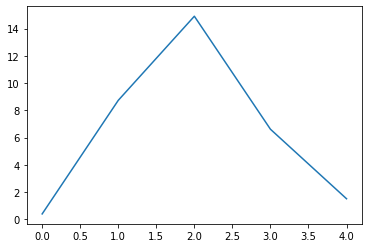

In [13]:
plt.plot(np.mean(WT_MM[:,:,0,4,:], axis=(1,2)))

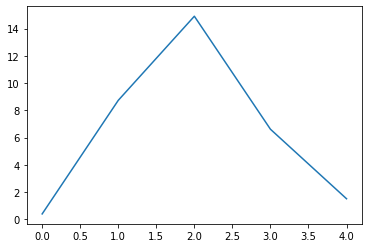

In [17]:
plt.plot(np.mean(SORTED[:,:,0,4,:], axis=(1,2)))

In [89]:
for yy in range(len(rgiYY)):
    for fm in range(2,7,1):
        for em in range(25):
            MonthAct = rgdTimeMM[rgdTimeMM.year == rgiYY[yy]]
            YYYYMM = [int(MonthAct.year[0]*100+MonthAct.month[mm]) for mm in range(len(MonthAct))]
            DATA = SORTED[:,yy,:,fm,em]
            grDATA = {}
            grDATA['YYYYMM'] = YYYYMM
            grDATA['dry']  = DATA[:,2].astype(int)
            grDATA['normal']  = DATA[:,1].astype(int)
            grDATA['monsoon']  = DATA[:,0].astype(int)
            df = pd.DataFrame(grDATA)
            df.to_csv('ECMWF_monthly_WTs_csv/ECMWF_WT-frequency_'+REGIONS[iRegion]+'_monsoon-WT-forecast_start-month-'+str(MonthAct.year[0])+str(StartMonths[fm]).zfill(2)+'_member-'+str(em+1).zfill(2)+'.csv', index=False)

In [63]:
# yy=21
# TEST = NMMEdata[:,yy,:,:,:,:,:]
# plt.plot(np.mean(TEST[:,3,10,10,0,:], axis=1))
# plt.plot(np.mean(TEST[:,4,10,10,0,:], axis=1))
# plt.plot(np.mean(TEST[:,5,10,10,0,:], axis=1))
# plt.plot(np.mean(TEST[:,6,10,10,0,:], axis=1))

# plt.plot(np.nanmean(ERA_annual[yy,:], axis=(1,2,3)), c='k',lw=1, alpha=1)

In [64]:
### Calculate skill to forecast the correct tercentile
DATA = np.load('/glade/u/home/prein/projects/Arizona_WTing/programs/plots/WTfreq-vs-PRaccum/PRISM_Monsoon-basins_PR.npz')
PR_basins = DATA['AnnualPR']
Years_PR = DATA['YEARS']

WT=0
FIN_MOD = rgiYY <= Years_PR[-1]
FIN_OBS = Years_PR >= rgiYY[0]


# ---- Work on WTS ---
YearRanksWTs = np.zeros((7, len(rgiYY[FIN_MOD]))); YearRanksWTs[:]=np.nan
for mm in range(2,7):
    MOD = np.mean(np.sum(WT_NMME[:,FIN_MOD,mm,:] == WTsort[iRegion][WT], axis=(0)), axis=1)
    MOD[MOD == 0] = np.nan
    FIN = ~np.isnan(MOD)
    MOD = signal.detrend(MOD[FIN])
    MOD =(MOD-np.nanmean(MOD))/np.nanstd(MOD)
    for yy in range(len(rgiYY[FIN_MOD])):
        try:
            YearRanksWTs[mm,yy] = (np.sum(MOD < MOD[yy])/len(MOD))*100.
        except:
            continue

# ---- Work on PR ---
YearRanksPR = np.zeros((len(Years_PR[FIN_OBS]))); YearRanksPR[:]=np.nan
OBS = PR_basins[:,iRegion]
OBS_Fin  = OBS[FIN_OBS]
# OBS_Fin = signal.detrend(OBS_Fin)
OBS_Fin =(OBS_Fin-np.nanmean(OBS_Fin))/np.nanstd(OBS_Fin)
for yy in range(len(Years_PR[FIN_OBS])):
    try:
        YearRanksPR[yy] = (np.sum(OBS_Fin < OBS_Fin[yy])/len(OBS_Fin))*100.
    except:
        continue

BS = 1000
WTbs = np.zeros((7,3,len(YearRanksPR),BS)); WTbs[:]=np.nan
PRbs = np.zeros((3,len(YearRanksPR),BS)); PRbs[:]=np.nan
from random import randrange
for bs in range(BS):
    INDEX = [randrange(len(YearRanksPR)) for ii in range(len(YearRanksPR))]
    WTbs[:,0,:,bs] = YearRanksWTs[:,INDEX] < np.percentile(YearRanksWTs[:,INDEX], 33.3, axis=1)[:,None]
    WTbs[:,1,:,bs] = (YearRanksWTs[:,INDEX] >= np.percentile(YearRanksWTs[:,INDEX], 33.3, axis=1)[:,None]) & (YearRanksWTs[:,INDEX] < np.percentile(YearRanksWTs[:,INDEX], 66.6, 1)[:,None])
    WTbs[:,2,:,bs] = YearRanksWTs[:,INDEX] >= np.percentile(YearRanksWTs[:,INDEX], 66.6, axis=1)[:,None]

    PRbs[0,:,bs] = YearRanksPR[INDEX] < np.percentile(YearRanksPR[INDEX], 33.3)
    PRbs[1,:,bs] = (YearRanksPR[INDEX] >= np.percentile(YearRanksPR[INDEX], 33.3)) & (YearRanksPR[INDEX] < np.percentile(YearRanksPR[INDEX], 66.6))
    PRbs[2,:,bs] = YearRanksPR[INDEX] >= np.percentile(YearRanksPR[INDEX], 66.6)

# calculate deviations from random chance
Perc = np.zeros((3,3,7))
for lh in range(3):
    Perc[lh,:,:] = np.nanpercentile(np.sum((PRbs[lh,:,:] == 1)[None,:] & (WTbs[:,lh,:] == 1), axis=1)/np.sum((PRbs[lh,:,:] == 1), axis=0)[None,:], (25,50,75),axis=1)


        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/Monsoon_forecast/IFS_NM-South_2021_Monsoon-Season-Forecast.pdf


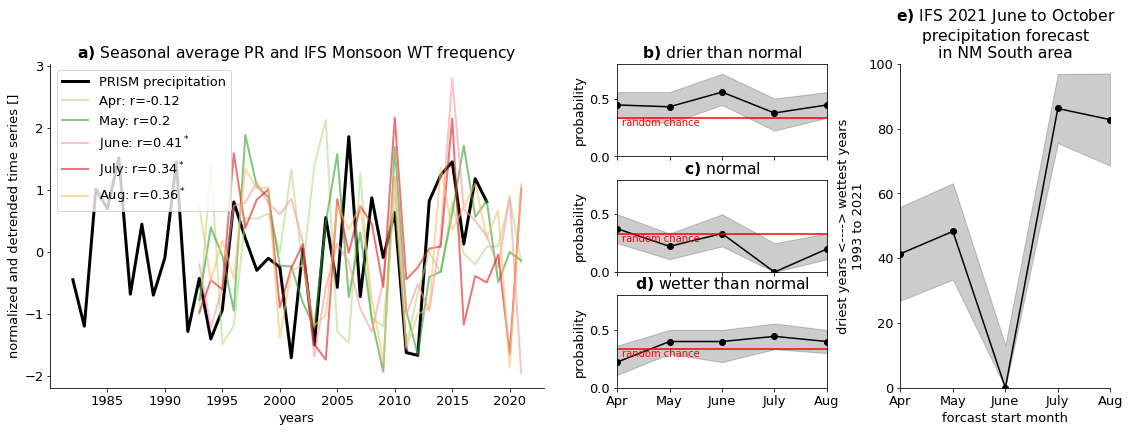

In [65]:
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(16,6))

gs1 = gridspec.GridSpec(3,4)
gs1.update(left=0.06, right=0.98,
           bottom=0.1, top=0.85,
           wspace=0.35, hspace=0.25)


# ======================================================
# --- PLOT FORECASTS ----
ax = plt.subplot(gs1[:,:2])
FOC_YYYY = np.array(range(1993,2019))

# Y_Fin = ~np.isnan(NAMM_PR[:,0,-1,mo,0,iRegion])
OBS = PR_basins[:,iRegion]
FIN = ~np.isnan(OBS)
# OBS = signal.detrend(OBS[FIN])
OBS =(OBS-np.mean(OBS))/np.std(OBS)


iYYO = np.isin(DATA['YEARS'][FIN],FOC_YYYY)
plt.plot(DATA['YEARS'][FIN],OBS, c='k', lw=3, label='PRISM precipitation')

COLORS = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
Months = ['Feb','Mar','Apr','May','June','July','Aug']
NAN = np.sum(WT_NMME == WTsort[iRegion][WT])
for mm in range(2,7):
    MOD = np.mean(np.sum(WT_NMME[:,:,mm,:]==WTsort[iRegion][WT], axis=(0)), axis=1)
    MOD[MOD == 0] = np.nan
    FIN = ~np.isnan(MOD)
    MOD = signal.detrend(MOD[FIN])
    MOD =(MOD-np.nanmean(MOD))/np.nanstd(MOD)
    iYYM = np.isin(rgiYY[FIN],FOC_YYYY)
    CC = scipy.stats.pearsonr(OBS[iYYO],MOD[iYYM])
    if CC[1] < 0.1:
        SIG = '$^*$'
    else:
        SIG = ' '
    plt.plot(rgiYY[FIN], MOD, color=COLORS[mm], label=Months[mm]+': r='+str(np.round(CC[0],2))+SIG, lw=2, alpha=0.6)
    
plt.legend()
ax.set_xlabel('years')
ax.set_ylabel('normalized and detrended time series []')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r"$\bf{" + 'a' + ")}$ "+'Seasonal average PR and '+NMME_models[mo][0]+' Monsoon WT frequency')


# ---- 2021 IN PERSPECTIVE TO PREVIOUS YEARS ---
ax = plt.subplot(gs1[:,3])
PercentOfYears = np.zeros((7)); PercentOfYears[:]=np.nan
for mm in range(2,7):
    MOD = np.mean(np.sum(WT_NMME[:,:,mm,:]==WTsort[iRegion][WT], axis=(0)), axis=1)
    MOD[MOD == 0] = np.nan
    FIN = ~np.isnan(MOD)
    MOD = signal.detrend(MOD[FIN])
    MOD =(MOD-np.nanmean(MOD))/np.nanstd(MOD)
    if np.sum(rgiYY[FIN] == 2021) == 1:
        PercentOfYears[mm] = (np.sum(MOD <MOD[-1])/len(MOD))*100.    
      
# rank of each ensemble member
RankPerMember = np.zeros((7,WT_NMME.shape[3])); RankPerMember[:]=np.nan
for mm in range(2,7):
    for en in range(WT_NMME.shape[3]):
        MOD = np.array(np.sum(WT_NMME[:,:,mm,en]==WTsort[iRegion][WT], axis=(0))).astype(float)
        MOD[MOD == 0] = np.nan
        FIN = ~np.isnan(MOD)
        MOD = signal.detrend(MOD[FIN])
        MOD =(MOD-np.nanmean(MOD))/np.nanstd(MOD)
        if np.sum(rgiYY[FIN] == 2021) == 1:
            RankPerMember[mm,en] = (np.sum(MOD <MOD[-1])/len(MOD))*100. 
            

# plot uncertainty
STD = np.std(RankPerMember, axis=1)
UPPER = PercentOfYears + STD/2.; UPPER[UPPER < 0] = 0
LOWER = PercentOfYears - STD/2.; LOWER[LOWER < 0] = 0
ax.fill_between(range(7), UPPER, LOWER, color='k', alpha = 0.2)
plt.plot(range(7), PercentOfYears, c='k')
plt.plot(range(7), PercentOfYears, 'ko')

ax.set_xlabel('forcast start month')
ax.set_ylabel('driest years <----> wettest years\n1993 to 2021')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim(0, 100)
plt.title(r"$\bf{" + 'e' + ")}$ "+NMME_models[mo][0]+' 2021 June to October\nprecipitation forecast\nin '+SRegionNames[iRegion]+' area')

ax.set_xticks(np.array(range(7)))
ax.set_xticklabels(Months, rotation = 0)
plt.xlim(2, 6)


# ------- PLOT DEVIATIONS FROM RANDOM --------
Label = ['b','c','d']
Terciles = ['drier than normal','normal','wetter than normal']
for lh in range(3):
    ax = plt.subplot(gs1[lh,2])
    plt.plot(range(7),Perc[lh,1,:], color='k')
    plt.plot(range(7),Perc[lh,1,:], 'ko')
    # plot uncertainty
    ax.fill_between(range(7), Perc[lh,0,:], Perc[lh,2,:], color='k', alpha = 0.2)
    ax.set_xticks(np.array(range(7)))
    if lh == 2:
        ax.set_xticklabels(Months, rotation = 0)
    else:
        ax.set_xticklabels(' '*len(Months), rotation = 0)
    plt.axhline(y=1/3, color='r', linestyle='-')
    plt.text(2.1,1/3,'random chance',color='r',ha='left',va='top',fontsize=10)
    plt.ylim(0, 0.8)
    plt.xlim(2, 6)
    plt.title(r"$\bf{" + str(Label[lh])+ ")}$ "+Terciles[lh])
    ax.set_ylabel('probability')


# Save the plot
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Monsoon_forecast/'
sPlotFile=sPlotDir
sPlotName= NMME_models[mo][0]+'_'+SRegionNames[iRegion].replace(' ', '-')+'_2021_Monsoon-Season-Forecast.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

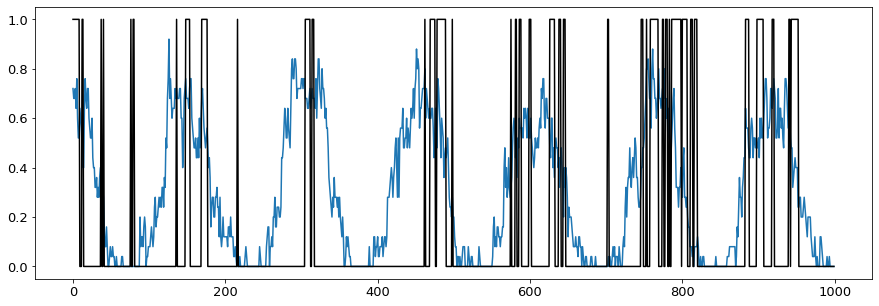

In [66]:
fig = plt.figure(figsize=(15,5))
DATAfile = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/IFS_Q850_1982-2010_AZ-West_ForecastMonths-2-3-4-5-6-7-8_MonsoonMonths-6-7-8-9-10.npz'
DATA = np.load(DATAfile)
Y_IFS = np.isin(rgiYY,DATA['YYYYY_NMME'])
M_IFS = np.isin(StartMonths,DATA['StartMonths'])
ERA_WTs = DATA['ERA_WTfin'].T

plt.plot(np.nanmean(WT_NMME[:,:,4,:]== 0, axis=2).T.flatten()[1600:2600])
plt.plot((ERA_WTs[:,:]==0).T.flatten()[1600:2600], c='k')

### Save the data for external processing

In [67]:
ERA_YYYY = np.unique(WTtime.year)
VARS_ET = '-'.join([ImputVars[mo][ii][0] for ii in range(len(ImputVars[mo]))])
PredMonths = '-'.join(np.array(MONTHS).astype('str'))
sStartMonths = '-'.join(np.array(StartMonths).astype('str'))
ERA_ETs = np.reshape(WTclusters[1], (len(YYYY_era), int(WTclusters[1].shape[0]/len(ERA_YYYY))))

SaveFile = SaveDir+NMME_models[mo][0].replace("/", "-")+'_'+VARS_ET+'_'+str(rgiYY[0])+'-'+str(rgiYY[-1])+'_'+iSelReg.replace(" ", "-")+'_ForecastMonths-'+sStartMonths+'_MonsoonMonths-'+PredMonths+'.npz'
SaveData = np.savez(SaveFile,
                   NMMEpredictors=NMMEdata,
                   TimeMonsSeason = rgdTimeACT[iTime],
                   YYYYY_NMME=rgiYY,
                   StartMonths=StartMonths,
                   rgrLatT=rgrLatT,
                   rgrLonT=rgrLonT,
                   WT_vars=VARS_ET,
                   WT_NMME=WT_NMME,
                   ERA_predictors = ERA_annual,
                   YYYY_ERA = YYYY_era,
                   ERA_WTfin=ERA_ETs)


In [68]:
SaveFile

'/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/IFS_Q850_1993-2021_NM-South_ForecastMonths-2-3-4-5-6-7-8_MonsoonMonths-6-7-8-9-10.npz'

Text(0, 0.5, 'Q850 [kg/kg]')

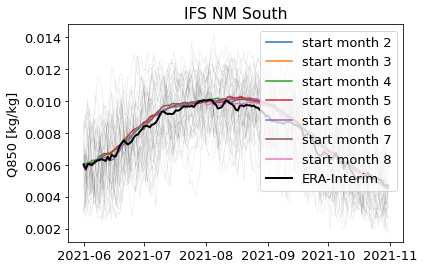

In [69]:
for yy in range(ERA_annual.shape[0]):
    plt.plot(DD_monsoonseason, np.nanmean(ERA_annual[yy,:], axis=(1,2,3)), c='k',lw=0.5, alpha=0.1)

for mm in range(len(StartMonths)):
    plt.plot(DD_monsoonseason,np.nanmean(NMMEdata[:,:,mm,:],axis=(1,2,3,4,5)), label='start month '+str(StartMonths[mm]))

plt.plot(DD_monsoonseason, np.nanmean(ERA_annual, axis=(0,2,3,4)), c='k',lw=2, label='ERA-Interim')
plt.legend()
plt.title(NMME_models[mo][0]+' '+iSelReg)
plt.ylabel('Q850 [kg/kg]')

Text(0.5, 1.0, 'IFS NM South')

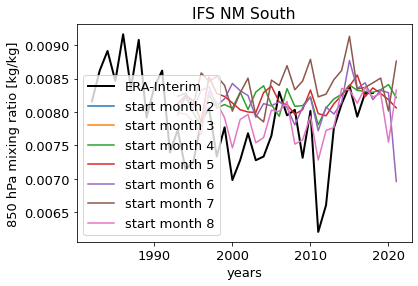

In [70]:
ERA_YYYY = np.unique(WTtime.year)
plt.plot(range(1982,2019,1),np.nanmean(ERA_annual[:,:], axis=(1,2,3,4)), c='k', lw=2, label='ERA-Interim')
for mm in range(len(StartMonths)):
    try:
        plt.plot(rgiYY,np.nanmean(NMMEdata[:,:,mm,:,:,0,:], axis=(0,2,3,4)), label='start month '+str(StartMonths[mm]))
        print(scipy.stats.pearsonr(np.nanmean(ERA_annual[np.isin(ERA_YYYY, rgiYY),:], axis=(1,2,3,4)),np.nanmean(NMMEdata[:,:,mm,:,:,0,:], axis=(0,2,3,4)))[0])
    except:
        continue

plt.xlabel('years')
plt.ylabel('850 hPa mixing ratio [kg/kg]')
plt.legend()
plt.title(NMME_models[mo][0]+' '+iSelReg)

ValueError: x and y must have same first dimension, but have shapes (29,) and (26,)

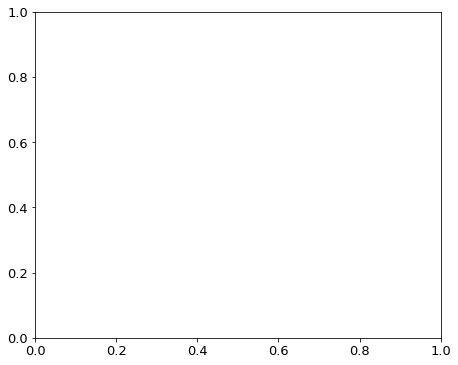

In [71]:
import seaborn as sns
from scipy import signal
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1)
# Normalized
EI_Norm = (ERA_annual[np.isin(ERA_YYYY, rgiYY),:] - np.nanmean(ERA_annual[np.isin(ERA_YYYY, rgiYY),:], axis=0)[None,:])/np.std(ERA_annual[np.isin(ERA_YYYY, rgiYY),:], axis=0)[None,:]
EI_Norm_DT = signal.detrend(EI_Norm[:,:], axis=0)
ax.plot(rgiYY,np.nanmean(EI_Norm_DT, axis=(1,2,3,4)), c='k', lw=2, label='ERA-Interim')

STD = np.nanstd(NMMEdata, axis=1); STD[STD == 0]=0.00001 # to avoid divisions by zero
NAAM_Norm = (NMMEdata - np.nanmean(NMMEdata, axis=1)[:,None,:])/STD[:,None,:]

NAAM_Norm_DT = signal.detrend(NAAM_Norm[:,:], axis=1)
for mm in range(len(StartMonths)):
    ax.plot(rgiYY,np.nanmean(NAAM_Norm_DT[:,:,mm,:,:,0,:], axis=(0,2,3,4)), label='start month '+str(np.array(StartMonths)[mm]))
    print(scipy.stats.pearsonr(np.nanmean(EI_Norm_DT, axis=(1,2,3,4)),np.nanmean(NAAM_Norm_DT[:,:,mm,:,:,0,:], axis=(0,2,3,4)))[0])

ax.set(xlabel='years', ylabel='normalized and detrended\n850 hPa mixing ratio [-]')
ax.legend()
plt.title(NMME_models[mo][0]+' '+iSelReg)

# scatter plot
mm=1
ax = fig.add_subplot(1, 2, 2)
ax = sns.regplot(x=np.nanmean(EI_Norm_DT, axis=(1,2,3,4)),y=np.nanmean(NAAM_Norm_DT[:,:,mm,:,:,0,:], axis=(0,2,3,4)))
plt.xlabel('ERAI normalized monsoon season Q850')
plt.ylabel(NMME_models[mo][0]+'\nnormalized monsoon season Q850')

### Centroid of Q850 anommaly

In [ ]:
TEST = np.moveaxis(np.moveaxis(np.moveaxis(NMMEdata,3,-1), 3,-1),3,-1)
TEST = TEST[WT_NMME == 0,:]
TEST = np.nanmean(TEST[:,:,:,0], axis=0)/np.nanmean(NMMEdata[:,:,:,:,:,0,:], axis=(0,1,2,5))

m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51,
    projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

xi,yi=m(rgrLonT,rgrLatT)
cs = m.contourf(xi,yi,TEST[:,:], cmap='coolwarm', levels=np.arange(-2,2.4,0.4), extend='both')

m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.drawstates(linewidth=0.25)

cb = colorbar(cs, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))

In [ ]:
wt = 0
fig = plt.figure(figsize=(15,5))
ERA_YYYY = np.unique(WTtime.year)
FocYYY = np.isin(ERA_YYYY, rgiYY)
ERA_ETs = np.reshape(WTclusters[1], (len(ERA_YYYY), int(WTclusters[1].shape[0]/len(ERA_YYYY))))
ERA_WTfin = np.mean(ERA_ETs[np.isin(ERA_YYYY, rgiYY),:] == wt, axis=1)


Heatmap = np.mean(WT_NMME == wt, axis=(0,3))
# Heatmap = Heatmap[FIN_Y,:][:,FIN_M]
Heatmap = np.append(Heatmap[:,:], ERA_WTfin[:,None], axis=1)

# normalize the heatmap
HeatmapNorm = (Heatmap - np.mean(Heatmap, axis=0)[None,:])/np.std(Heatmap, axis=0)[None,:]
HeatmapNormDetrend = signal.detrend(HeatmapNorm[:,:], axis=0)

ax = sns.heatmap(HeatmapNormDetrend[:,:].T, cmap = 'coolwarm', vmin=-2, vmax=2, linewidths=1, 
                             cbar_kws={'label': 'normalized & detrended\nMonsoon day frequency'})
plt.plot([0,len(rgiYY)],[5,5], lw=4, c='k')
ax.set_xticklabels(rgiYY, rotation=90)
ax.set_yticklabels(list(np.array(['Feb','Mar','Apr','May','Jun'])[FIN_M])+['ERAI'], rotation=0)
plt.xlabel('years')

In [ ]:
wt = 0
plt.plot(rgdTimeACT[iTime], np.mean(WT_NMME[:,:,:,:] == wt, axis=(1,3)))
plt.plot(rgdTimeACT[iTime], np.mean(ERA_ETs == wt, axis=0), c='k')
plt.ylabel('Monsoon day frequency')

In [ ]:
# Correlate Monsoon day frequencyt with average Q over season
MonsoonDayFreq = np.array([np.sum((WT_NMME[:,ii,:,:] == 0), axis=0) for ii in range(WT_NMME.shape[1])])
MonsoonDayFreq = np.mean(MonsoonDayFreq, axis=2)

NORM1= np.nanmean(ERA_annual[np.isin(ERA_YYYY, rgiYY),:], axis=(1,2,3,4))
NORM1 = (NORM1-np.mean(NORM1))/np.std(NORM1)
plt.plot(rgiYY,NORM1, c='k', lw=2, label='ERA-Interim Q')

NORM2 = Heatmap[:,-1]
NORM2 = (NORM2-np.mean(NORM2))/np.std(NORM2)
plt.plot(rgiYY,NORM2, c='k', lw=2, label='ERA-Interim WT', ls='--')

mm=2
NORM = (MonsoonDayFreq[:,mm]-np.mean(MonsoonDayFreq[:,mm]))/np.std(MonsoonDayFreq[:,mm])
plt.plot(rgiYY[:],NORM, c='r', lw=2, label='IFS WT')

NORM3 = np.nanmean(NAAM_Norm_DT[:,:,2,:,:,0,:], axis=(0,2,3,4))
NORM3 = (NORM3-np.mean(NORM3))/np.std(NORM3)
plt.plot(rgiYY[:],NORM3, c='r', lw=2, label='IFS Q', ls='--')

plt.legend()

print(np.round(scipy.stats.pearsonr(NORM2,NORM),3))
print(np.round(scipy.stats.pearsonr(NORM1,NORM3),3))

In [ ]:
import seaborn as sns
ax = sns.regplot(x=Heatmap[:,-2],y=Heatmap[:,1])
for mm in range(np.sum(FIN_M)):
    print(scipy.stats.pearsonr(Heatmap[:,-1],Heatmap[:,mm])[0])

In [ ]:
ax = sns.regplot(x=HeatmapNormDetrend[:,-1],y=HeatmapNormDetrend[:,-3])
plt.xlabel('ERAI normalized Monsoon day frequ.')
plt.ylabel(NMME_models[mo][0]+'\nnormalized Monsoon day frequ.')
for mm in range(np.sum(FIN_M)):
    print(np.round(scipy.stats.pearsonr(HeatmapNormDetrend[:,-1],HeatmapNormDetrend[:,mm]),3))

In [ ]:
ERA_YYYY = np.unique(WTtime.year)
plt.plot(rgiYY,Heatmap[:,-1], c='k', lw=2, label='ERA-Interim')
for mm in range(np.sum(FIN_M)):
    plt.plot(rgiYY,Heatmap[:,mm], label='start month '+str(np.array(StartMonths)[mm]))
plt.xlabel('years')
plt.ylabel('Monsoon day frequency [%]')
plt.legend()
plt.title(NMME_models[mo][0]+' '+iSelReg)

In [ ]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(rgiYY,HeatmapNormDetrend[:,-1], c='k', lw=2, label='ERA-Interim')
for mm in range(np.sum(FIN_M)):
    ax.plot(rgiYY,HeatmapNormDetrend[:,mm], label='start month '+str(np.array(StartMonths)[mm]))
plt.xlabel('years')
plt.ylabel('normalized & detrendet\nMonsoon day frequency [%]')
plt.legend()
plt.title(NMME_models[mo][0]+' '+iSelReg)

# scatter plot
mm=2
ax = fig.add_subplot(1, 2, 2)
ax = sns.regplot(x=HeatmapNormDetrend[:,-1],y=HeatmapNormDetrend[:,mm])
plt.xlabel('ERAI normalized Monsoon day frequ.')
plt.ylabel(NMME_models[mo][0]+'\nnormalized Monsoon day frequ.')

In [ ]:
print(scipy.stats.pearsonr(HeatmapNormDetrend[:,-1],np.mean(HeatmapNormDetrend[:,[3]], axis=1)))
print(scipy.stats.pearsonr(HeatmapNormDetrend[:,-1],np.mean(HeatmapNormDetrend[:,2:4], axis=1)))